- Focused on training using the ground truth (perfect RPN) bounding boxes

In [1]:
import os
import torch
import pandas as pd  
from project.dataset import Dataset, VALDODataset
from project.preprocessing import NiftiToTensorTransform, get_transform
from project.utils import collatev2, compute_statistics 
from torch.utils.data import DataLoader
from project.model import ISAVIT, feeder
from torch.optim import Adam
import torch.nn.functional as F
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from project.model.feeder import Feeder
import seaborn as sns
import torch.nn as nn

c:\Users\nigel\Documents\Thesis\Thesis\.env\Lib\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
c:\Users\nigel\Documents\Thesis\Thesis\.env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import logging
from datetime import datetime as dtt
import os

path = 'logs'
os.makedirs(path, exist_ok=True)
dte = dtt.now().strftime('%b_%d_%Y_%H%M%S')

logger = logging.getLogger('nigel')
fh = logging.FileHandler(f'logs/ViT{dte}.log')
formatter = logging.Formatter(
    '%(asctime)s - %(levelname)s - %(message)s'
)

logger.setLevel(logging.DEBUG)
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)

logger.addHandler(fh)

dte

'Nov_06_2024_143844'

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
image_size = 300
patch_size = 16

config = {
    'model': ISAVIT(
        d_model=512,
        patch_size=patch_size,
        dim_ff=1600
    ).to(device),
    'optimizer': torch.optim.Adam,
    'device': device,
    'epochs': 2,
    'loss': nn.BCEWithLogitsLoss(),
    # 'loss': nn.MSELoss(),
    'lr': 0.0001
}

c:\Users\nigel\Documents\Thesis\Thesis\.env\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [5]:
from project.model import Feeder, RPN, GCRPN

resize = get_transform(
    height=patch_size,
    width=patch_size,
    p=1.0,
    rpn_mode=False
)

feeder = Feeder(resize)
rpn = RPN(
    input_dim=512,
    output_dim=4,
    image_size=image_size,
    nh=4,
)

stone = GCRPN(
    rpn=rpn,
    feeder=feeder,
    image_size=image_size,
    patch_size=patch_size
)

324


In [6]:
stone.rpn.load_state_dict(torch.load('RPN_test15_weights_Nov_02_2024_192506.pt'))

C:\Users\nigel\AppData\Local\Temp\ipykernel_12776\957646178.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  stone.rpn.load_state_dict(torch.load('RPN_test15_weights_Nov_

<All keys matched successfully>

## Load the dataset

In [7]:
ds = Dataset()

data = pd.read_csv('targets.csv')
data.shape

(7986, 8)

In [8]:
data = data.query('has_microbleed_slice == 1').reset_index(drop=True)
data

,mri,masks,target,has_microbleed_case,has_microbleed_slice,cohort,max_value,slices
0,c:\Users\nigel\Documents\Thesis\Dataset\VALDO_...,c:\Users\nigel\Documents\Thesis\Dataset\VALDO_...,8,1,1,1,928.405273,35
1,c:\Users\nigel\Documents\Thesis\Dataset\VALDO_...,c:\Users\nigel\Documents\Thesis\Dataset\VALDO_...,9,1,1,1,928.405273,35
2,c:\Users\nigel\Documents\Thesis\Dataset\VALDO_...,c:\Users\nigel\Documents\Thesis\Dataset\VALDO_...,11,1,1,1,928.405273,35
3,c:\Users\nigel\Documents\Thesis\Dataset\VALDO_...,c:\Users\nigel\Documents\Thesis\Dataset\VALDO_...,12,1,1,1,928.405273,35
4,c:\Users\nigel\Documents\Thesis\Dataset\VALDO_...,c:\Users\nigel\Documents\Thesis\Dataset\VALDO_...,15,1,1,1,928.405273,35
...,...,...,...,...,...,...,...,...
359,c:\Users\nigel\Documents\Thesis\Dataset\VALDO_...,c:\Users\nigel\Documents\Thesis\Dataset\VALDO_...,25,1,1,3,241.000000,36
360,c:\Users\nigel\Documents\Thesis\Dataset\VALDO_...,c:\Users\nigel\Documents\Thesis\Dataset\VALDO_...,26,1,1,3,241.000000,36
361,c:\Users\nigel\Documents\Thesis\Dataset\VALDO_...,c:\Users\nigel\Documents\Thesis\Dataset\VALDO_...,24,1,1,3,448.000000,39
362,c:\Users\nigel\Documents\Thesis\Dataset\VALDO_...,c:\Users\nigel\Documents\Thesis\Dataset\VALDO_...,25,1,1,3,448.000000,39


### `DataLoader` Generator

In [9]:
def iqr(data, col):
    q3 = data[col].quantile(0.75)
    q1 = data[col].quantile(0.25)
    iqr = q3-q1
    new = data[(data[col] < (q3 + 1.5*iqr)) & (data[col] > (q1 - 1.5*iqr))]
    return new

In [10]:
from sklearn.model_selection import train_test_split

def make_loaders(data,
                 cohort,
                 batch_size,
                 test_size=0.2,
                 random_state=12,
                 target_shape=(300, 300),
                 rpn_mode=True,
                 logger=None
                ):
    data = data[data.cohort == cohort]
    # data = iqr(data, 'max_value')
    
    s = f'Creating loaders for Cohort {cohort}\n'

    data_train, data_test = train_test_split(
        data,
        test_size=test_size,
        random_state=random_state
    )

    s += f'TRAIN & TEST: {data_train.shape, data_test.shape}\n'

    paths = data_train.mri.unique().tolist()
    s += f'Total Unique MRI Samples in data_train: {len(paths)}\n'
    
    global_min, global_max = compute_statistics(paths)
    s += f'GLOBAL MIN & MAX {global_min, global_max}\n'

    transform = NiftiToTensorTransform(
        target_shape=target_shape,
        rpn_mode=rpn_mode,
        normalization=(global_min, global_max)
    )

    feedset_transform = NiftiToTensorTransform(
        target_shape=target_shape,
        rpn_mode=~rpn_mode,
        normalization=(global_min, global_max)
    )

    train_set = VALDODataset(
        cases=data_train.mri.tolist(),
        masks=data_train.masks.tolist(),
        target=data_train.target.tolist(),
        transform=transform
    )
    val_set = VALDODataset(
        cases=data_test.mri.tolist(),
        masks=data_test.masks.tolist(),
        target=data_test.target.tolist(),
        transform=transform
    )

    feedset = VALDODataset(
        cases=data.mri,
        masks=data.masks,
        target=data.target,
        transform=feedset_transform
    )


    train_loader = DataLoader(
        train_set,
        shuffle=True,
        batch_size=batch_size,
        collate_fn=collatev2
    )
    val_loader = DataLoader(
        val_set,
        shuffle=True,
        batch_size=batch_size,
        collate_fn=collatev2
    )

    if logger != None:
        logger.info(s)
    else:
        print(s)
    
    return train_loader, val_loader, feedset

In [11]:
tl, vl, feedset = make_loaders(
    data=data,
    cohort=1,
    rpn_mode=False,
    batch_size=20
)

Creating loaders for Cohort 1
TRAIN & TEST: ((36, 8), (9, 8))
Total Unique MRI Samples in data_train: 8
GLOBAL MIN & MAX (0.0, 1417.92822265625)



C:\Users\nigel\AppData\Local\Temp\ipykernel_12776\189831911.py:39: DeprecationWarning: Bitwise inversion '~' on bool is deprecated and will be removed in Python 3.16. This returns the bitwise inversion of the underlying int object and is usually not what you expect from negating a bool. Use the 'not' operator for boolean negation or ~int(x) if you really want the bitwise inversion of the underlying int.
  rpn_mode=~rpn_mode,


### Test Bounding box extraction with train and val feedset

### Fitter

In [12]:
from project import Fitter

class ViTFitter(Fitter):
    
    def fit(self, train_loader, val_loader, stage1):
        train_history = []
        val_history = []
        for epoch in range(self.epochs):
            self.log(f'EPOCH {epoch} ==============================')
            print(f'EPOCH {epoch} ==============================')
            train_loss = self.train_one_epoch(train_loader)
            val_loss = self.validation(val_loader, stage1)
            train_history.append(train_loss)
            val_history.append(val_loss)
        return train_history, val_history

    def train_one_epoch(self, train_loader):
        self.model.train()
        loss_history = []
        counter = 0
        for batch in train_loader:
            Y = []
            T = []
            for slices, masks, target, case in batch:
                num_slices = slices.shape[0]
                
                regions = feedset.locate_case_by_mri(case)
                bboxes = regions[1].view(regions[1].shape[0], -1)
                bbox = bboxes[target].int().tolist()
                
                self.log(bbox)
                # print(set(bbox))
                x = feeder(slices, bbox, 16)
                t = feeder(masks, bbox, 16)
                self.log(x.shape)
                self.log(t.shape)
                # x = x.view(num_slices, 1, -1).float().to(self.device)
                # masks = t.view(num_slices, 1, -1).float().to(self.device)
                x = x.flatten(2).float().to(self.device)
                t = t.flatten(2).float().to(self.device)

                # print(x.shape, t.shape)
                y = self.model(x, target)
                Y.append(y)
                T.append(t[target])
            
            losses = self.loss(torch.stack(Y), torch.stack(T))
            # losses = self.loss(torch.stack(T), torch.stack(Y))
            loss_history.append(losses.detach().cpu().numpy())
            self.optimizer.zero_grad()
            losses.backward()
            self.optimizer.step()
            counter += len(batch)
            if counter % 100 == 0:
                logger.info(f'Progress:\t{counter}/{len(feedset)}')
                logger.info(f'Current error:\t{losses}')
        
        return loss_history
    def validation(self, val_loader, stage1):
        self.model.eval()
        loss_history = []
        with torch.inference_mode():
            for batch in val_loader:
                Y = []
                T = []
                for slices, masks, target, case in batch:
                    slices = slices.squeeze(1).float()
                    masks = masks.float()
                    x, t = stage1(slices, masks, target)
                    x = x.flatten(2).float().to(self.device)
                    t = t.flatten(2).float().to(self.device)
                    print(x.shape, t.shape)
                    y = self.model(x, target)
                    Y.append(y)
                    T.append(t[target])
                
                losses = self.loss(torch.stack(Y), torch.stack(T))
                loss_history.append(losses.cpu().numpy())
        return loss_history

In [13]:
fitter = ViTFitter(config, logger=logger)

In [14]:
thist, vhist = fitter.fit(tl, vl, stone)

EPOCH 0 ==============================
torch.Size([35, 1, 256]) torch.Size([35, 1, 256])
torch.Size([35, 1, 256]) torch.Size([35, 1, 256])
torch.Size([35, 1, 256]) torch.Size([35, 1, 256])
torch.Size([35, 1, 256]) torch.Size([35, 1, 256])
torch.Size([35, 1, 256]) torch.Size([35, 1, 256])
torch.Size([35, 1, 256]) torch.Size([35, 1, 256])
torch.Size([35, 1, 256]) torch.Size([35, 1, 256])
torch.Size([35, 1, 256]) torch.Size([35, 1, 256])
torch.Size([35, 1, 256]) torch.Size([35, 1, 256])
EPOCH 1 ==============================
torch.Size([35, 1, 256]) torch.Size([35, 1, 256])
torch.Size([35, 1, 256]) torch.Size([35, 1, 256])
torch.Size([35, 1, 256]) torch.Size([35, 1, 256])
torch.Size([35, 1, 256]) torch.Size([35, 1, 256])
torch.Size([35, 1, 256]) torch.Size([35, 1, 256])
torch.Size([35, 1, 256]) torch.Size([35, 1, 256])
torch.Size([35, 1, 256]) torch.Size([35, 1, 256])
torch.Size([35, 1, 256]) torch.Size([35, 1, 256])
torch.Size([35, 1, 256]) torch.Size([35, 1, 256])


In [15]:
import winsound

winsound.Beep(500, 500)
winsound.Beep(500, 500)
winsound.Beep(500, 500)

<Axes: >

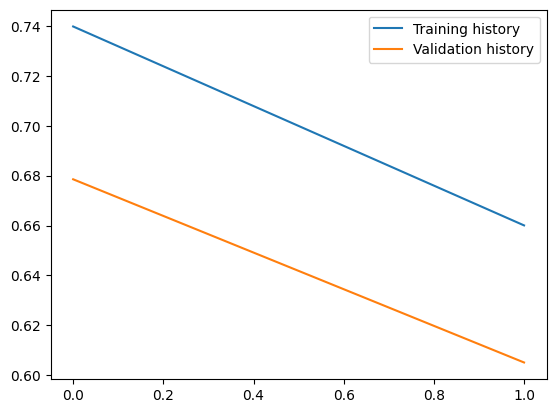

In [17]:
import seaborn as sns
import numpy as np

th = torch.tensor(np.array(thist))
vh = torch.tensor(np.array(vhist))
# print(th.shape)
sns.lineplot(th.mean(1), label='Training history')
sns.lineplot(vh.mean(1), label='Validation history')

In [18]:
sample = next(enumerate(tl))
case = sample[1][0]
slices, masks, target, path = case

<Axes: >

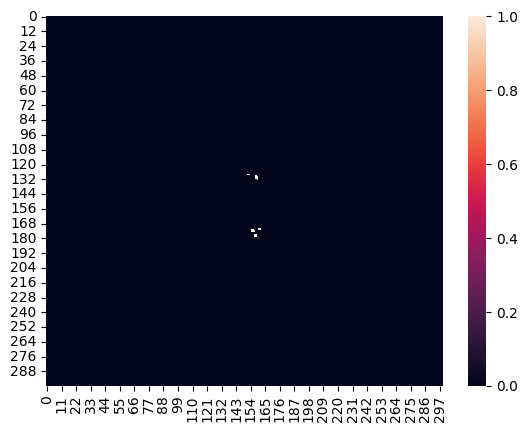

In [19]:
sns.heatmap(masks[target].squeeze())

In [20]:
slices = slices.squeeze(1).float()
masks = masks.float()

In [21]:
x, t = stone(slices, masks, target)

<Axes: title={'center': 'Mask Slice Crop'}>

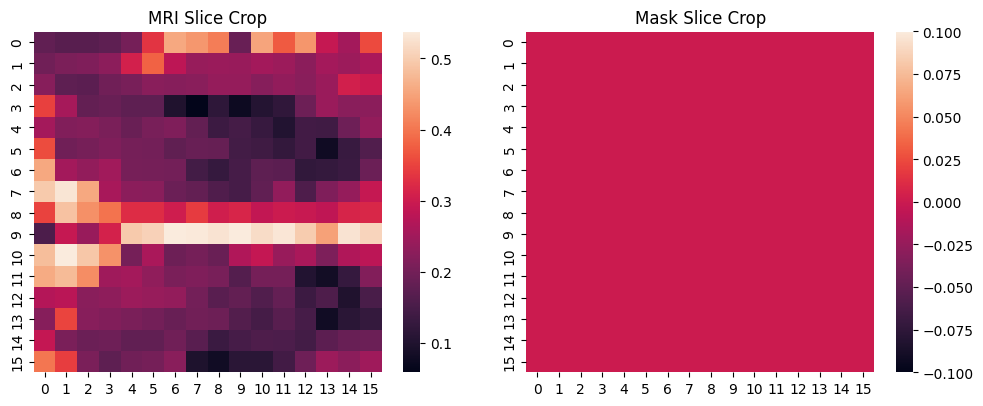

In [22]:
f, a = plt.subplots(1, 2, figsize=(10, 4))

f.tight_layout()
ax1 = a.flat[0]
ax2 = a.flat[1]
ax1.set_title('MRI Slice Crop')
ax2.set_title('Mask Slice Crop')
sns.heatmap(x[target].squeeze(), ax=ax1)
sns.heatmap(t[target].squeeze(), ax=ax2)

In [23]:
vit = config['model']

In [24]:
x.shape

torch.Size([35, 1, 16, 16])

In [25]:
y = vit(x.flatten(2).to(device), target)
y = y.view(patch_size, patch_size)

<Axes: title={'center': 'Mask Truth'}>

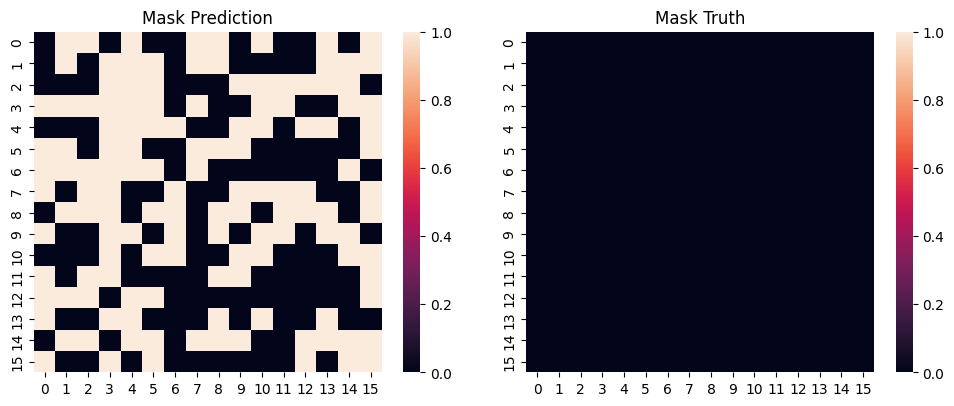

In [26]:
f, a = plt.subplots(1, 2, figsize=(10, 4))

f.tight_layout()
ax1 = a.flat[0]
ax2 = a.flat[1]
ax1.set_title('Mask Prediction')
ax2.set_title('Mask Truth')
sns.heatmap((y > -0.3).detach().cpu(), ax=ax1, vmax=1)
sns.heatmap(t[target].squeeze(), ax=ax2, vmax=1)